# Sentiment Analysis Using NLP

## Introduction
* **Natural Language Processing (NLP):** The discipline of computer science, artificial intelligence and linguistics that is concerned with the creation of computational models that process and understand natural language. These include: making the computer understand the semantic grouping of words (e.g. cat and dog are semantically more similar than cat and spoon), text to speech, language translation and many more.

* **Sentiment Analysis:** It is the interpretation and classification of emotions (positive, negative and neutral) within text data using text analysis techniques. Sentiment analysis allows organizations to identify public sentiment towards certain words or topics.

In this notebook, we'll develop a **Sentiment Analysis model** to categorize a tweet as **Positive or Negative.**

## Table of Contents
1. [Importing dependencies](#p1)
2. [Importing dataset](#p2)
3. [Text Preprocessing](#p3)
4. [Analysing the data](#p4)
5. [Train Test Split](#p5)
6. [TF-IDF Vectoriser](#p6)
7. [Transforming The Dataset](#p7)
8. [Creating and Evaluating Models](#p8)
    * [BernoulliNB Model](#p8-1)
    * [LinearSVC Model](#p8-2)
    * [Logistic Regression Model](#p8-3)
9. [Saving the Models](#p9)
10. [Using The Model](#p10)

## <a name="p2">Importing Dependencies</a>

In [1]:
#utilities
import re
import pickle
import numpy as np
import pandas as pd

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

#nltk
from nltk.stem import WordNetLemmatizer

#sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report,confusion_matrix

## <a name="p2">Importing Dataset</a>
The dataset being used is the **sentiment140 dataset**. It contains 1,600,000 tweets extracted using the **Twitter API**. The tweets have been annotated **(0 = Negative, 4 = Positive)** and they can be used to detect sentiment.

**It contains the following 6 fields:**
1. **sentiment**: the polarity of the tweet *(0 = negative, 4 = positive)*
2. **ids**: The id of the tweet *(2087)*
3. **date**: the date of the tweet *(Sat May 16 23:58:44 UTC 2009)*
4. **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
5. **user**: the user that tweeted *(robotickilldozr)*
6. **text**: the text of the tweet *(Lyx is cool)*

In [55]:
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('training.1600000.processed.noemoticon.csv',encoding=DATASET_ENCODING,names=DATASET_COLUMNS)

In [3]:
dataset.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
dataset = dataset[['sentiment','text']]

In [5]:
dataset.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [6]:
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

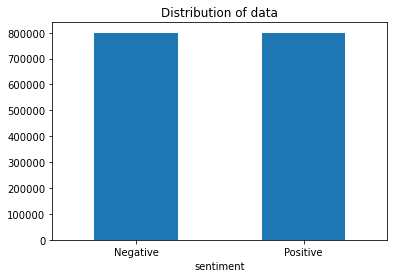

In [9]:
#the plot below indicates that the dataset is balanced
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [10]:
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

## <a name="p3">Text Preprocessing</a>
**Text Preprocessing** is traditionally an important step for **Natural Language Processing (NLP)** tasks. It transforms text into a more digestible form so that machine learning algorithms can perform better.

**The Preprocessing steps taken are:**
1. **Lower Casing:** Each text is converted to lowercase.
2. **Replacing URLs:** Links starting with **"http" or "https" or "www"** are replaced by **"URL"**.
3. **Replacing Emojis:** Replace emojis by using a pre-defined dictionary containing emojis along with their meaning. *(eg: ":)" to "EMOJIsmile")*
4. **Replacing Usernames:** Replace @Usernames with word **"USER"**. *(eg: "@Kaggle" to "USER")*
5. **Removing Non-Alphabets:** Replacing characters except Digits and Alphabets with a space.
6. **Removing Consecutive letters:** 3 or more consecutive letters are replaced by 2 letters. *(eg: "Heyyyy" to "Heyy")*
7. **Removing Short Words:** Words with length less than 2 are removed.
8. **Removing Stopwords:** Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. *(eg: "the", "he", "have")*
9. **Lemmatizing:** Lemmatization is the process of converting a word to its base form. *(e.g: “Great” to “Good”)*

In [11]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [12]:
#function for cleaning text
def preprocess(textdata):
    processedText = []
    
    wordLemm = WordNetLemmatizer()
    
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"    
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        tweet = re.sub(urlPattern,'URL',tweet)
        tweet = re.sub(userPattern,'USER',tweet)
        tweet = re.sub(alphaPattern,' ',tweet)
        tweet = re.sub(sequencePattern,seqReplacePattern,tweet)
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji,'EMOJI'+emojis[emoji])
        
        tweetwords = ''
        for word in tweet.split():
            if len(word)>1:
                word = wordLemm.lemmatize(word)
                tweetwords+=(word+' ')
        processedText.append(tweetwords)
    return processedText

In [18]:
import time
t = time.time()
processedtext = preprocess(text)
print('Text Preprocessing Complete')
print(f'Time Taken : {round(time.time()-t)} seconds')

Text Preprocessing Complete
Time Taken : 180 seconds


## <a name="p4">Analysing the data</a>
Now we're going to analyse the preprocessed data to get an understanding of it. We'll plot **Word Clouds** for **Positive and Negative** tweets from our dataset and see which words occur the most.

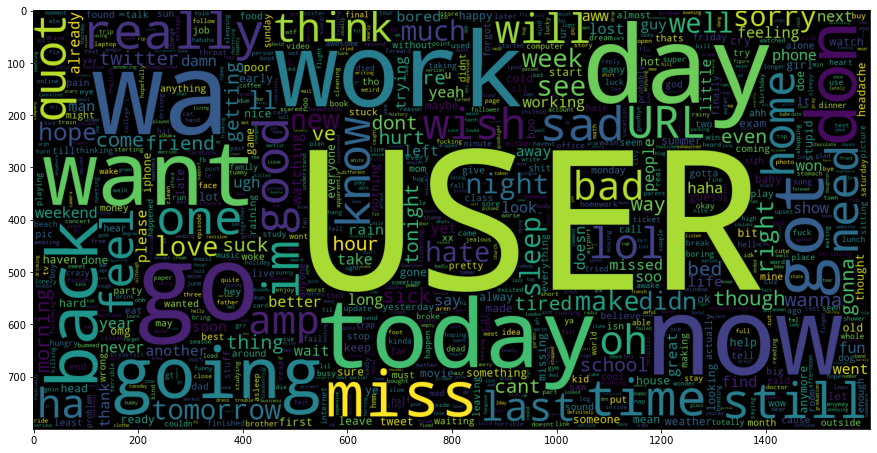

In [56]:
#wordcloud for negative words
data_neg = processedtext[:800000]
plt.figure(figsize=(15,15))
wc = WordCloud(max_words=1000,width=1600,height=800,collocations=False).generate(' '.join(data_neg))
plt.imshow(wc)

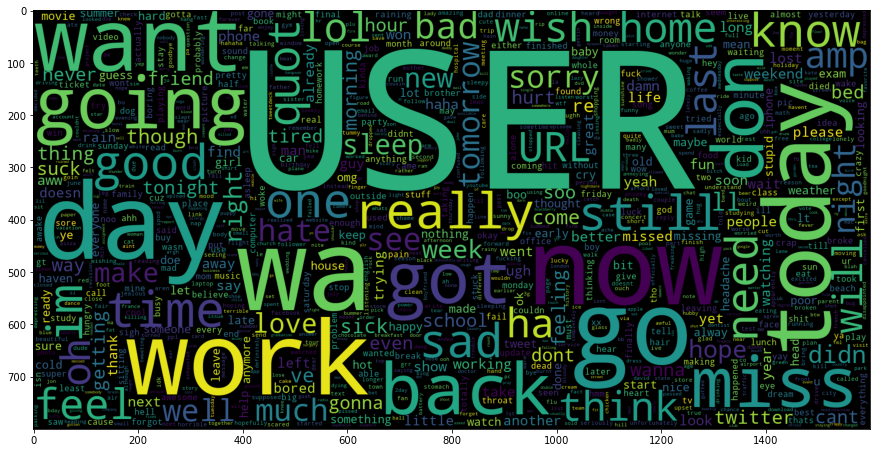

In [57]:
#wordcloud for positive words
data_pos = processedtext[800000:]
plt.figure(figsize=(15,15))
wc = WordCloud(max_words=1000,width=1600,height=800,collocations=False).generate(' '.join(data_neg))
plt.imshow(wc)

## <a name="p5">Train Test Split</a>

In [28]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment, test_size=0.05, random_state=0)

## <a name="p6">TF-IDF Vectoriser</a>
**TF-IDF indicates what the importance of the word is in order to understand the document or dataset.** Let us understand with an example. Suppose you have a dataset where students write an essay on the topic, My House. In this dataset, the word a appears many times; it’s a high frequency word compared to other words in the dataset. The dataset contains other words like home, house, rooms and so on that appear less often, so their frequency are lower and they carry more information compared to the word. This is the intuition behind TF-IDF.

In [30]:
vectorizer = TfidfVectorizer(ngram_range=(1,2),max_features=500000)
vectorizer.fit(X_train)
print('Vectorizer trained')
print('No of features words:',len(vectorizer.get_feature_names_()))

Vectorizer trained


/home/ashpheonix/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


No of features words: 500000


## <a name="p7">Transforming The Dataset</a>

In [31]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

## <a name="p8">Creating and Evaluating Models</a>
We're creating 3 different types of model for our sentiment analysis problem: 
* **Bernoulli Naive Bayes (BernoulliNB)**
* **Linear Support Vector Classification (LinearSVC)**
* **Logistic Regression (LR)**

In [32]:
#function to evaluate model
def model_Evaluate(model):
    y_pred = model.predict(X_test)
    print(classification_report(y_test,y_pred))
    cf_matrix = confusion_matrix(y_test,y_pred)
    
    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(cf_matrix,annot=labels,cmap='Blues',fmt='',xticklabels=categories,yticklabels=categories)
    
    plt.xlabel('Predicted Values',fontdict={'size':14},labelpad=10)
    plt.ylabel('Actual Values',fontdict={'size':14},labelpad=10)
    

### <a name="p8-1">BernoulliNB Model</a>

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     39989
           1       0.80      0.81      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



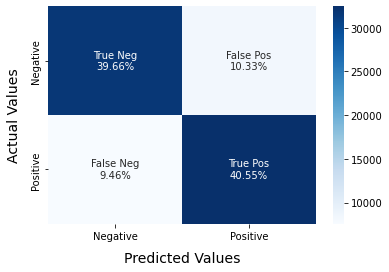

In [34]:
BNBmodel = BernoulliNB(alpha=2)
BNBmodel.fit(X_train,y_train)
model_Evaluate(BNBmodel)

### <a name="p8-2">LinearSVC Model</a>

              precision    recall  f1-score   support

           0       0.82      0.81      0.82     39989
           1       0.81      0.83      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



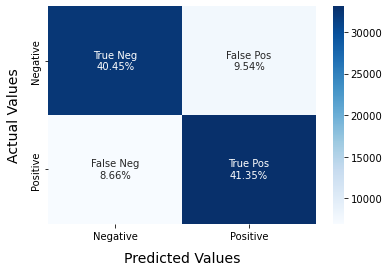

In [35]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train,y_train)
model_Evaluate(SVCmodel)

### <a name="p8-3">Logistic Regression Model</a>

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     39989
           1       0.82      0.84      0.83     40011

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



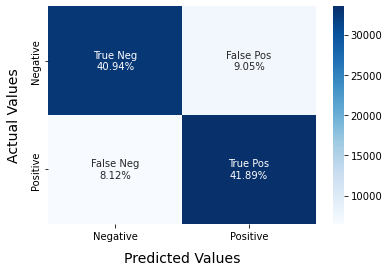

In [36]:
LRmodel = LogisticRegression(C = 2,max_iter=1000,n_jobs=-1)
LRmodel.fit(X_train,y_train)
model_Evaluate(LRmodel)

## <a name="p9">Saving the Models</a>

In [37]:
file = open('vectorizer.pickle','wb')
pickle.dump(vectorizer,file)
file.close()

file = open('Sentiment_LR.pickle','wb')
pickle.dump(LRmodel,file)
file.close()

file = open('Sentiment_BNB.pickle','wb')
pickle.dump(BNBmodel,file)
file.close()

## <a name="p10">Using the Model.</a>

In [38]:
def load_model():
    file = open('vectorizer.pickle','rb')
    vectorizer = pickle.load(file)
    file.close()
    
    file = open('Sentiment_LR.pickle','rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectorizer ,LRmodel


In [50]:
def predict(vectorizer,model,text):
    textdata = vectorizer.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    data = []
    
    for text,pred in zip(text,sentiment):
        data.append((text,pred))
        
    df = pd.DataFrame(data,columns=['Text','Sentiment'])
    df['Sentiment'] = df['Sentiment'].replace([0,1],['Negative','Positive'])
    return df

In [53]:
# Text to classify should be in a list.
text = ["I hate twitter",
        "Good luck for your exam",
        "Mr. Stark, I don't feel so good"]
#loading the model
#vectorize,LRmodel = load_model()
df = predict(vectorizer,LRmodel,text)

In [54]:
print(df)

                              Text Sentiment
0                   I hate twitter  Negative
1          Good luck for your exam  Positive
2  Mr. Stark, I don't feel so good  Negative
